In [1]:
##nodejs:  https://docs.aws.amazon.com/sdk-for-javascript/v2/developer-guide/setting-up-node-on-ec2-instance.html

# !pip install "jupyterlab>=3" "ipywidgets>=7.6"
# !pip install jupyter-dash
# !jupyter lab build


# !pip install snowflake --user
# !pip install snowflake-connector-python --user
# !pip install category_encoders
# !pip install xgboost
# !pip install lightgbm --user
import os
import sys
path=!pwd
sys.path.append(os.path.join(path[0], '..'))
from utils import *
import snowflake.connector
from datetime import timedelta

from category_encoders import OneHotEncoder
import xgboost as xgb
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as r2_score
import sklearn.model_selection

import plotly.express as px

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_PROD","DATASCIENCE_STAGE")
cur = ctx.cursor()

# Decay

In [220]:
def get_decay_data_title(df_plt, grpby):
    df_plt = df_plt[grpby + ['days_since_premiere','first_views']].sort_values(by=grpby+['days_since_premiere'])
    df_plt['first_views_sum'] = df_plt.groupby(grpby)['first_views'].transform('sum')
    df_plt['first_views_cumsum'] = df_plt.groupby(by=grpby)['first_views'].cumsum()
    df_plt['first_views_cumpct'] = df_plt['first_views_cumsum'] / df_plt['first_views_sum']
    df_plt['first_views_pct'] = df_plt['first_views'] / df_plt['first_views_sum']
    df_plt.reset_index(inplace=True)
    return df_plt

date_eval_end = '2021-07-01'

df_raw=pd.read_csv('s3://datascience-hbo-users/users/tjung/psi/fv_actual_0922.csv')
df= df_raw.copy()
df['effective_start_date'] = pd.to_datetime(df['effective_start_date'])
df = df[df['effective_start_date']<=date_eval_end]
df = df[df.title_name!='Dune']

grpby_title= ['tier','content_category','category','title_name', 'title_id','season_number',
        'program_type','effective_start_date']

df = get_decay_data_title(df, grpby_title)

df['start_year'] = pd.to_datetime(df['effective_start_date']).dt.year
df['start_month'] = pd.to_datetime(df['effective_start_date']).dt.month
df['start_day'] = pd.to_datetime(df['effective_start_date']).dt.weekday
df['start_year_month'] = df['effective_start_date'].dt.strftime('%Y-%m')
df['start_quarter'] = df['effective_start_date'].dt.quarter

bins=[0, 5000,500000, np.inf]
labels=[1,2,3]
df['first_views_bins'] = pd.cut(df['first_views_sum'], bins=bins, labels=labels)
display(df.head())

,index,tier,content_category,category,title_name,title_id,season_number,program_type,effective_start_date,days_since_premiere,first_views,first_views_sum,first_views_cumsum,first_views_cumpct,first_views_pct,start_year,start_month,start_day,start_year_month,start_quarter,first_views_bins
0,6605,1,movies,Pay1,Tenet,GYEq4eApHYpA4cwEAAAAC,0,acquired,2021-05-02,0,3464,43052,3464,0.080461,0.080461,2021,5,6,2021-05,2,2
1,6606,1,movies,Pay1,Tenet,GYEq4eApHYpA4cwEAAAAC,0,acquired,2021-05-02,1,1862,43052,5326,0.123711,0.043250,2021,5,6,2021-05,2,2
2,6607,1,movies,Pay1,Tenet,GYEq4eApHYpA4cwEAAAAC,0,acquired,2021-05-02,2,1445,43052,6771,0.157275,0.033564,2021,5,6,2021-05,2,2
3,6608,1,movies,Pay1,Tenet,GYEq4eApHYpA4cwEAAAAC,0,acquired,2021-05-02,3,1219,43052,7990,0.185590,0.028315,2021,5,6,2021-05,2,2
4,6609,1,movies,Pay1,Tenet,GYEq4eApHYpA4cwEAAAAC,0,acquired,2021-05-02,4,923,43052,8913,0.207029,0.021439,2021,5,6,2021-05,2,2


In [159]:
df[(df.tier==1) & (df.content_category==a) & (df.start_year_month>='2021-03')& (df.start_year_month<='2021-06')]

,index,tier,content_category,category,title_name,title_id,season_number,program_type,effective_start_date,days_since_premiere,first_views,first_views_sum,first_views_cumsum,first_views_cumpct,start_year,start_month,start_day,start_year_month,start_quarter,first_views_bins


Excluding popcorn


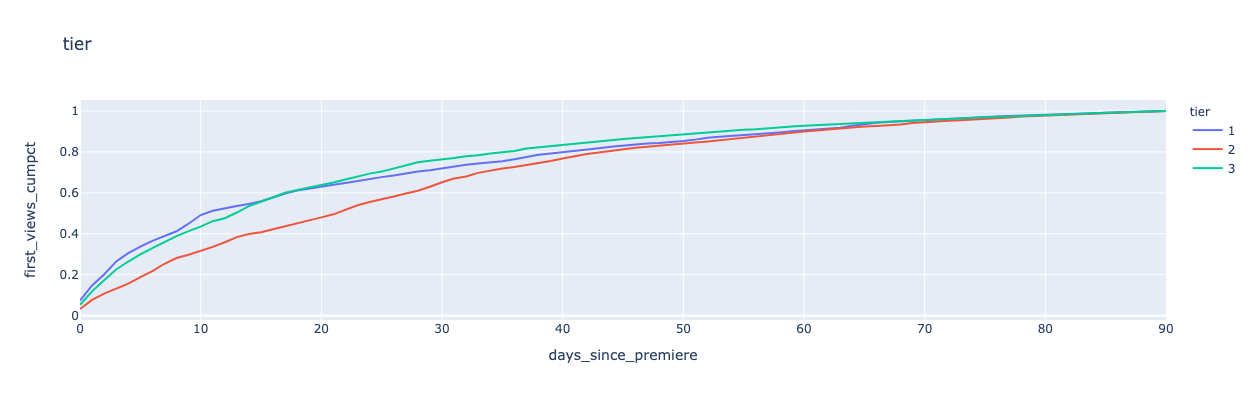

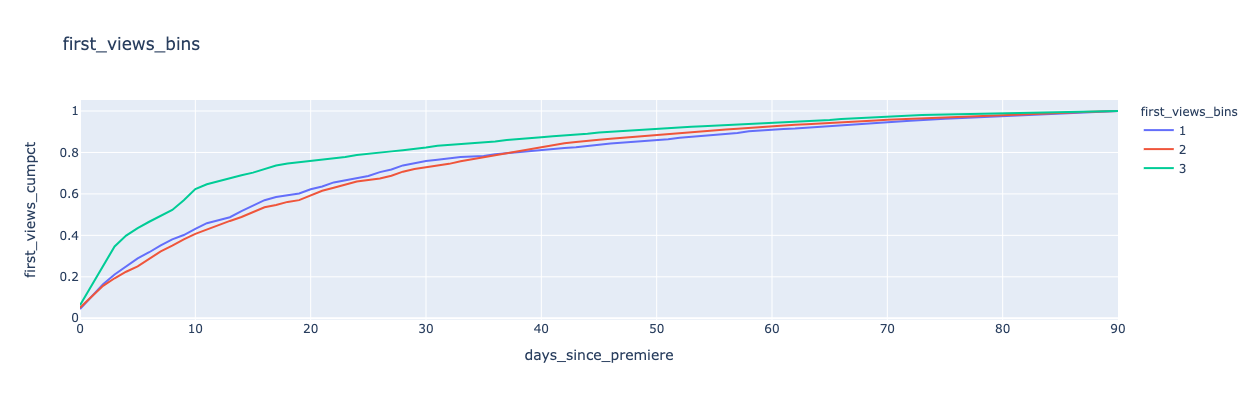

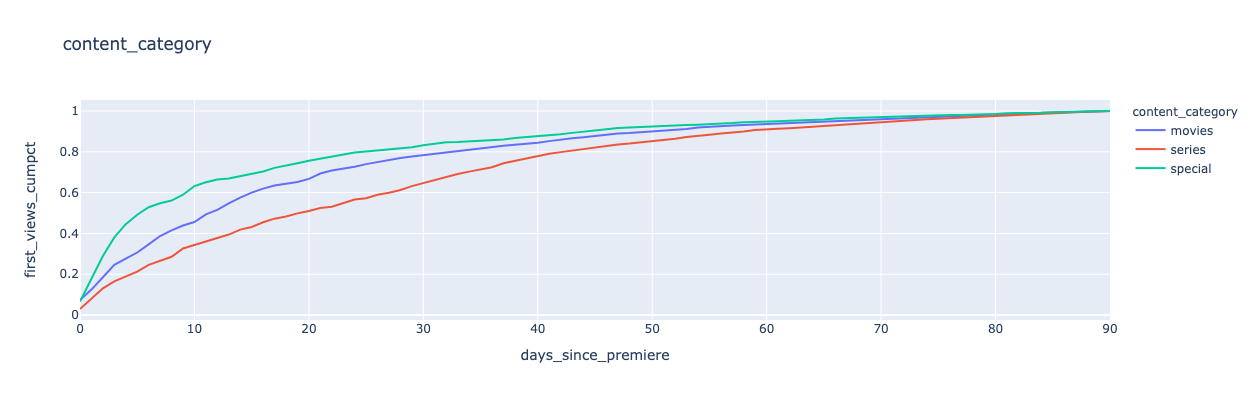

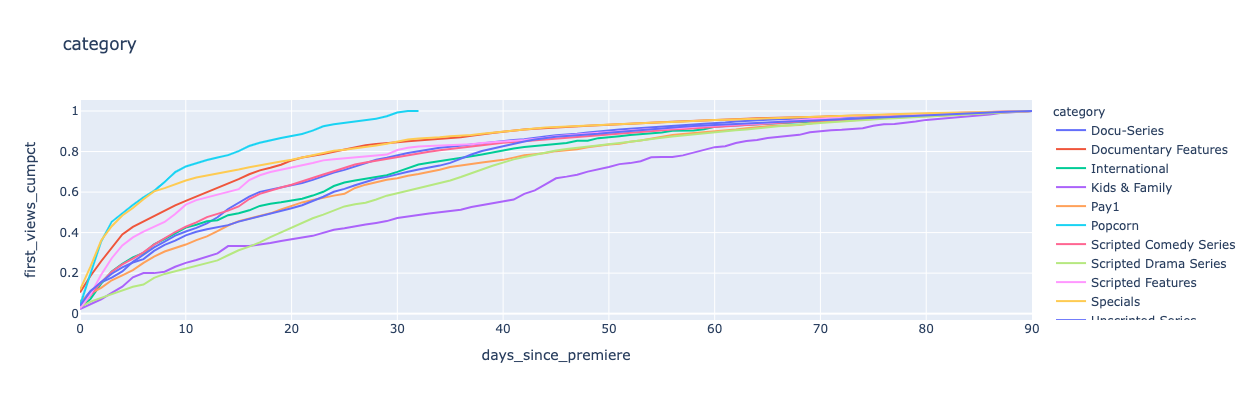

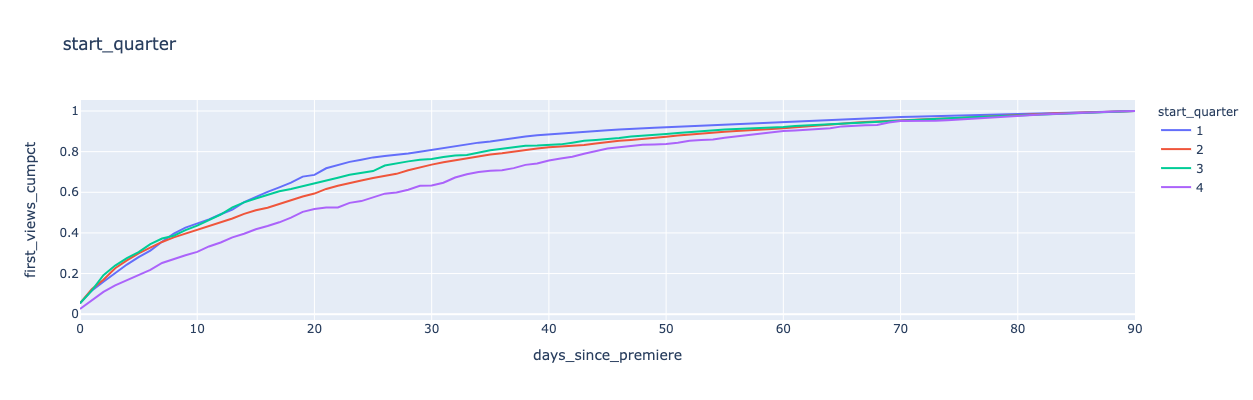

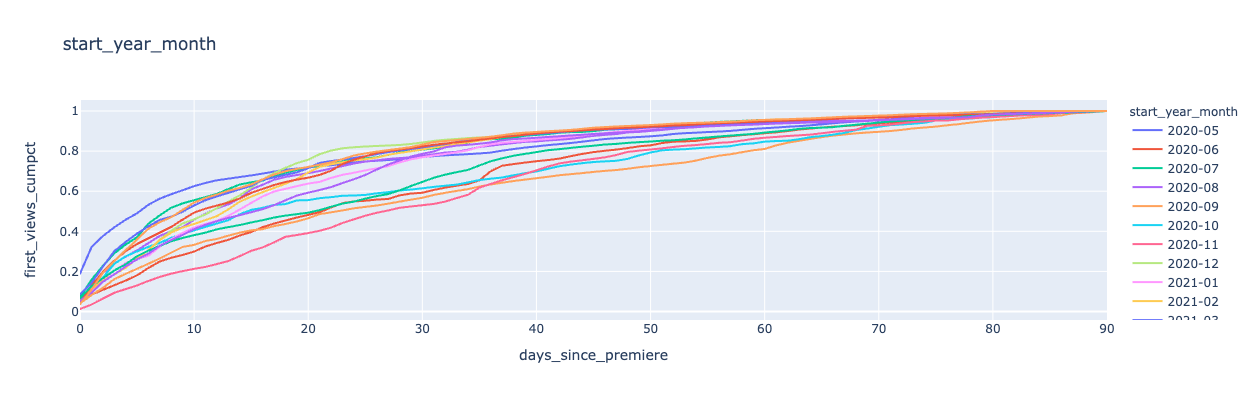

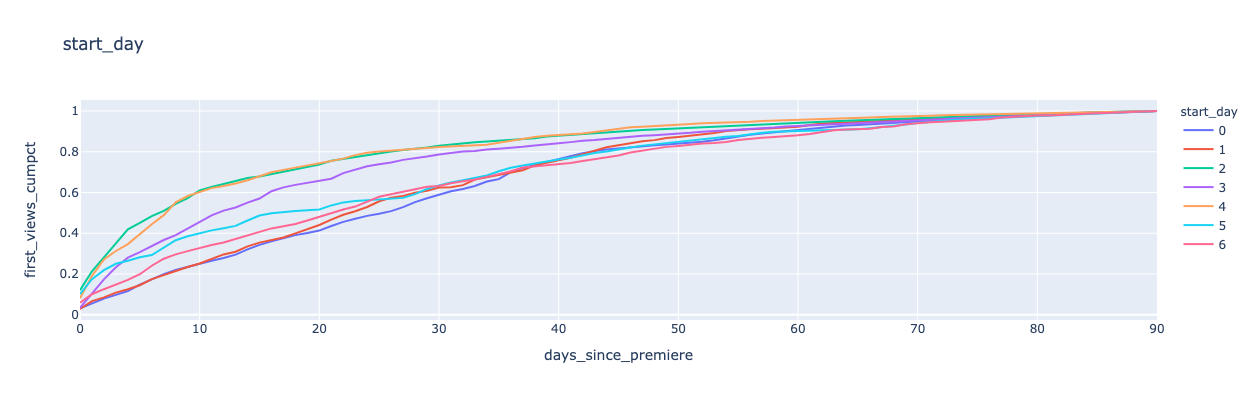

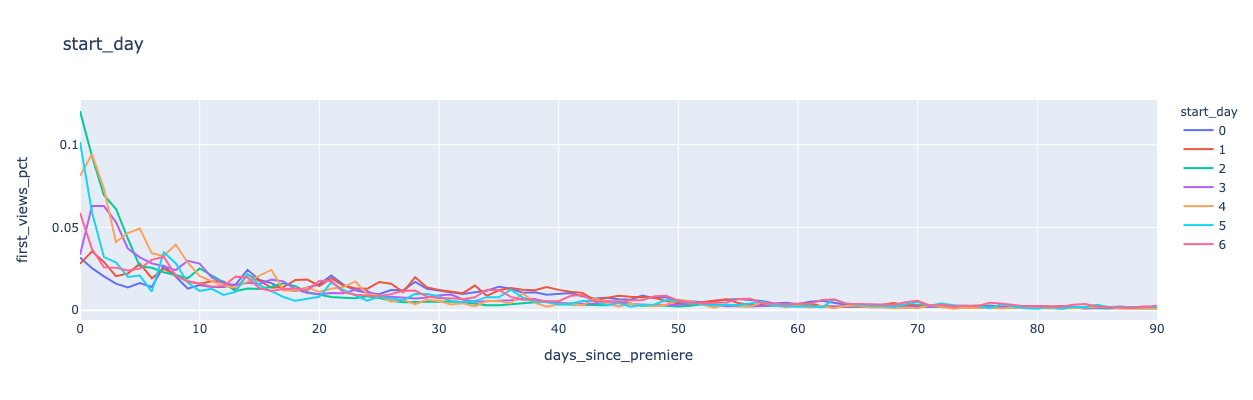


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


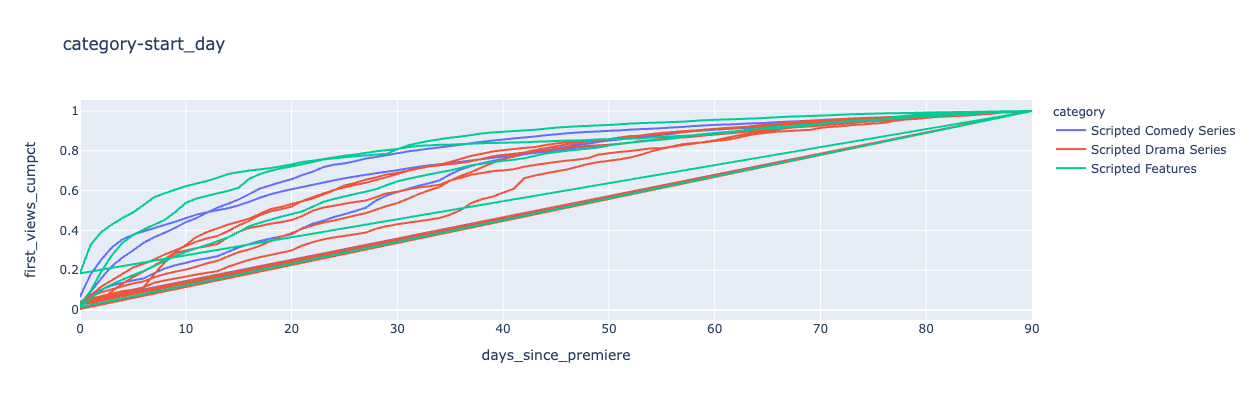

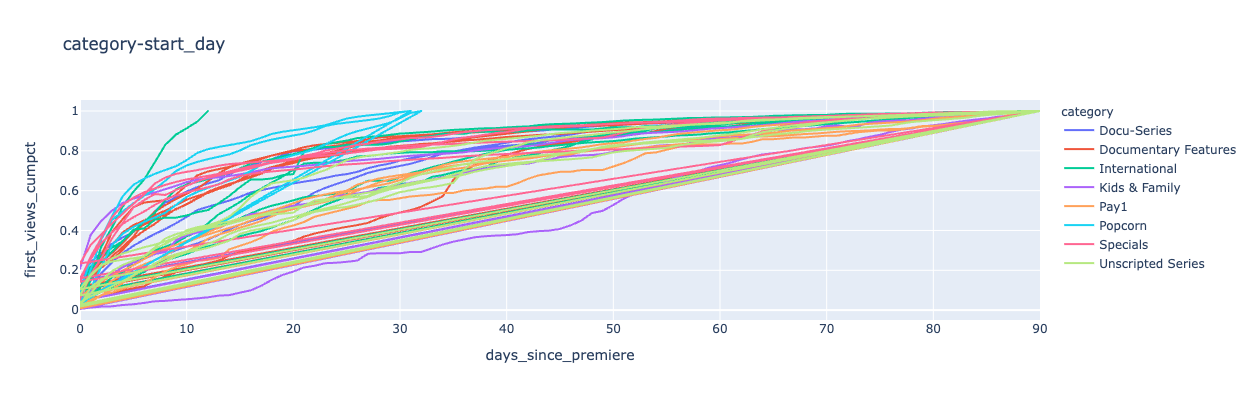

In [222]:
## Group by year-month and plot cumulative first view over days_since_premiere

def get_decay_data(df_plt, grpby):
    df_plt = df_plt[grpby + ['title_id','days_since_premiere','first_views_pct','first_views_cumpct']].sort_values(by=grpby+['days_since_premiere'])
    df_plt = df_plt.groupby(by=grpby + ['days_since_premiere']).agg({'first_views_cumpct':'median','first_views_pct':'median','title_id':'nunique'})
    df_plt.reset_index(inplace=True)
    return df_plt

def get_decay_plot(df_plt, var, grpby, text, title=''):
    if title=='':
        title = grpby
    df_plt[grpby] = df_plt[grpby].astype(str)
    fig = px.line(df_plt,
                  x='days_since_premiere', 
                  y=var, 
                  title=title,
                  color=grpby, 
                  hover_data=text,
                  width=800, height=400)
    fig.show()
    return 


print('Excluding popcorn')
grpby='tier'
df_plt = get_decay_data(df[df.category!='Popcorn'], [grpby])
get_decay_plot(df_plt, 'first_views_cumpct', grpby, [grpby])


grpby='first_views_bins'
df_plt = get_decay_data(df[df.category!='Popcorn'], [grpby])
get_decay_plot(df_plt, 'first_views_cumpct', grpby, [grpby])


grpby='content_category'
df_plt = get_decay_data(df[df.category!='Popcorn'], [grpby])
get_decay_plot(df_plt, 'first_views_cumpct', grpby, [grpby])

grpby='category'
df_plt = get_decay_data(df, [grpby])
get_decay_plot(df_plt, 'first_views_cumpct', grpby, [grpby])

grpby='start_quarter'
df_plt = get_decay_data(df[df.category!='Popcorn'], [grpby])
get_decay_plot(df_plt, 'first_views_cumpct', grpby, [grpby])

grpby='start_year_month'
df_plt = get_decay_data(df[df.category!='Popcorn'], [grpby])
get_decay_plot(df_plt, 'first_views_cumpct', grpby, [grpby])

grpby='start_day'
df_plt = get_decay_data(df[df.category!='Popcorn'], [grpby])
get_decay_plot(df_plt, 'first_views_cumpct', grpby, [grpby])

grpby='start_day'
df_plt = get_decay_data(df[df.category!='Popcorn'], [grpby])
get_decay_plot(df_plt, 'first_views_pct', grpby, [grpby])


grpby=['category','start_day']
df_plt = get_decay_data(df, grpby)

grpby='category'
get_decay_plot(df_plt[df_plt.category.str.contains('Scripted')], 'first_views_cumpct', grpby, ['start_day','title_id'], 'category-start_day')

grpby='category'
get_decay_plot(df_plt[~df_plt.category.str.contains('Scripted')], 'first_views_cumpct', grpby, ['start_day','title_id'], 'category-start_day')


In [215]:
df_plt.category.unique()

array(['Docu-Series', 'Documentary Features', 'International',
       'Kids & Family', 'Pay1', 'Popcorn', 'Scripted Comedy Series',
       'Scripted Drama Series', 'Scripted Features', 'Specials',
       'Unscripted Series'], dtype=object)

In [ ]:
## Plot 